# Composition MDP (temporary)

This is a smaller part of the original scenario
[(see here)](./03-composition-mdp.ipynb)

In [1]:
from mdp_dp_rl.algorithms.dp.dp_analytic import DPAnalytic

from docs.notebooks.utils import render_target, render_service, render_composition_mdp, print_policy_data, \
    print_value_function, print_q_value_function
from stochastic_service_composition.composition import composition_mdp
from stochastic_service_composition.services import Service, build_system_service, build_service_from_transitions
from stochastic_service_composition.target import build_target_from_transitions, Target



def build_target_service() -> Target:
    """Build the target service."""
    transition_function = {
        "t0": {
            "hot_air_on": ("t1", 0.6, 5),
            "move_to_kitchen": ("t2", 0.4, 3),
        },
        "t1": {"hot_air_off": ("t0", 0.5, 4), "hot_air_on": ("t1", 0.5, 2)},
        "t2": {
            "move_to_bathroom": ("t0", 0.7, 3),
            "move_to_kitchen": ("t2", 0.3, 3),
        },
    }

    initial_state = "t0"
    final_states = {"t0"}

    return build_target_from_transitions(
        transition_function, initial_state, final_states
    )

target_service = build_target_service()

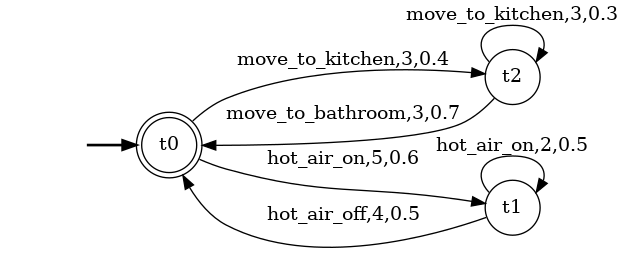

In [2]:
render_target(target_service)

## Service community

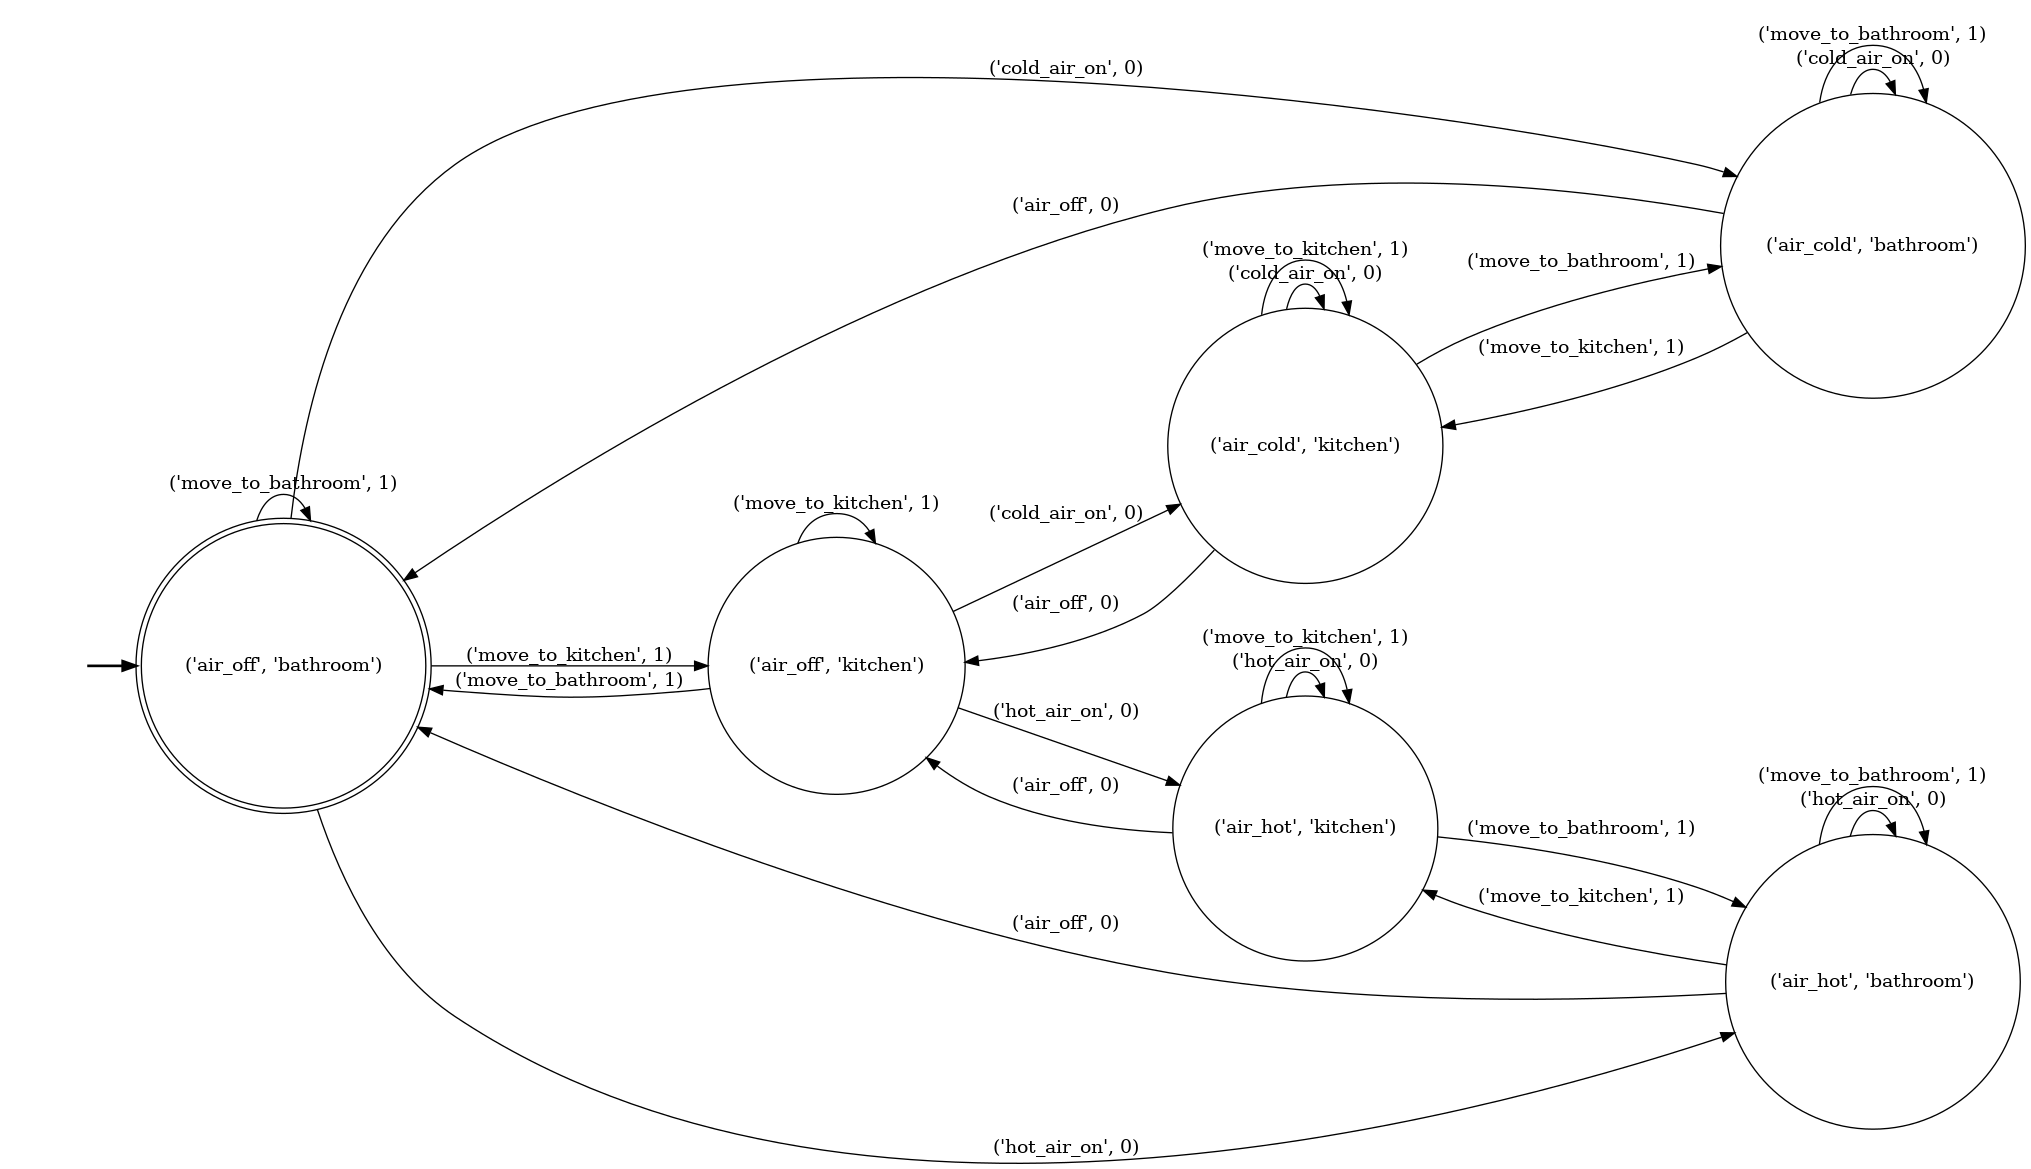

In [3]:
def bathroom_heating_device() -> Service:
    """Build the bathroom heating device."""
    transitions = {
        "air_cold": {
            "cold_air_on": "air_cold",
            "air_off": "air_off",
        },
        "air_off": {
            "cold_air_on": "air_cold",
            "hot_air_on": "air_hot",
        },
        "air_hot": {"hot_air_on": "air_hot", "air_off": "air_off"},
    }
    final_states = {"air_off"}
    initial_state = "air_off"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore


def user_behaviour() -> Service:
    """It is the user behaviour service."""
    transitions = {
        "bathroom": {
            "move_to_bathroom": "bathroom",
            "move_to_kitchen": "kitchen",
        },
        "kitchen": {
            "move_to_bathroom": "bathroom",
            "move_to_kitchen": "kitchen",
        },
    }
    initial_state = "bathroom"
    final_states = {"bathroom"}
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore


bathroom_heating_service = bathroom_heating_device()
user_behaviour = user_behaviour()

all_services = [
    bathroom_heating_service,
    user_behaviour
]
system_service = build_system_service(*all_services)


render_service(system_service)

## Compute the composition MDP

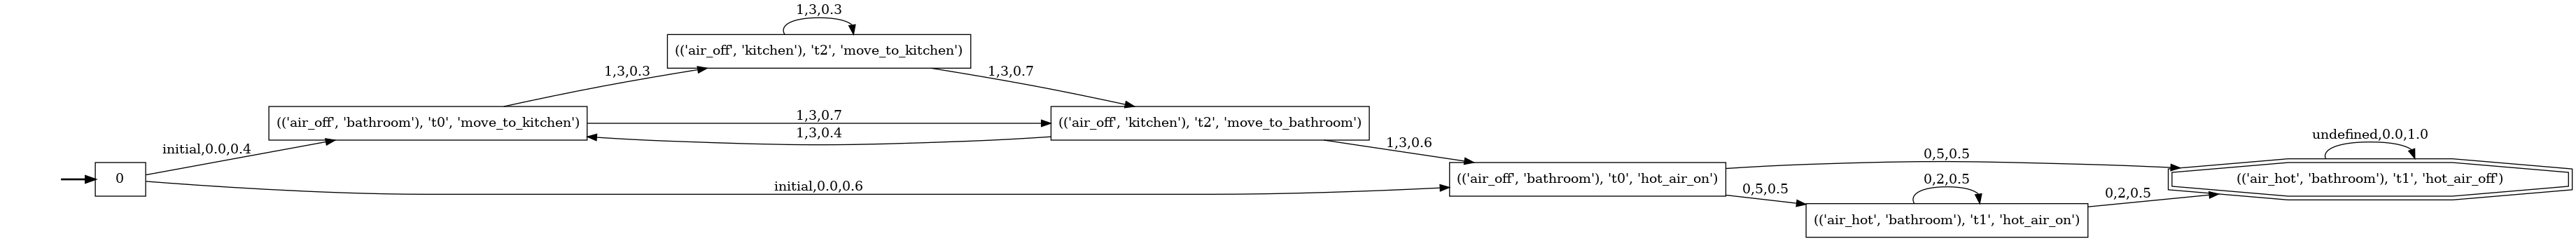

In [4]:
mdp = composition_mdp(target_service, *all_services)

render_composition_mdp(mdp)

In [5]:

print(f"Number of states: {len(mdp.all_states)}")
print("Transitions:")

for state, transitions in mdp.transitions.items():
    for action, next_states in transitions.items():
        for next_state, prob in next_states.items():
            print(state, action, next_state, prob)


Number of states: 7
Transitions:
0 initial (('air_off', 'bathroom'), 't0', 'hot_air_on') 0.6
0 initial (('air_off', 'bathroom'), 't0', 'move_to_kitchen') 0.4
(('air_off', 'bathroom'), 't0', 'hot_air_on') 0 (('air_hot', 'bathroom'), 't1', 'hot_air_off') 0.5
(('air_off', 'bathroom'), 't0', 'hot_air_on') 0 (('air_hot', 'bathroom'), 't1', 'hot_air_on') 0.5
(('air_off', 'bathroom'), 't0', 'move_to_kitchen') 1 (('air_off', 'kitchen'), 't2', 'move_to_bathroom') 0.7
(('air_off', 'bathroom'), 't0', 'move_to_kitchen') 1 (('air_off', 'kitchen'), 't2', 'move_to_kitchen') 0.3
(('air_hot', 'bathroom'), 't1', 'hot_air_off') undefined (('air_hot', 'bathroom'), 't1', 'hot_air_off') 1.0
(('air_hot', 'bathroom'), 't1', 'hot_air_on') 0 (('air_hot', 'bathroom'), 't1', 'hot_air_off') 0.5
(('air_hot', 'bathroom'), 't1', 'hot_air_on') 0 (('air_hot', 'bathroom'), 't1', 'hot_air_on') 0.5
(('air_off', 'kitchen'), 't2', 'move_to_bathroom') 1 (('air_off', 'bathroom'), 't0', 'hot_air_on') 0.6
(('air_off', 'kitchen'

The optimal policy is:

In [6]:
opn = DPAnalytic(mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
value_function = opn.get_value_func_dict(opt_policy)
q_value_function = opn.get_act_value_func_dict(opt_policy)

# remove '0' state to sort output
opt_policy.policy_data.pop(0, None)
value_function.pop(0, None)
q_value_function.pop(0, None)

print_policy_data(opt_policy)
print()
print_value_function(value_function)
print()
print_q_value_function(q_value_function)

Policy:
State=(('air_hot', 'bathroom'), 't1', 'hot_air_off'),	Action=undefined
State=(('air_hot', 'bathroom'), 't1', 'hot_air_on'),	Action=0
State=(('air_off', 'bathroom'), 't0', 'hot_air_on'),	Action=0
State=(('air_off', 'bathroom'), 't0', 'move_to_kitchen'),	Action=1
State=(('air_off', 'kitchen'), 't2', 'move_to_bathroom'),	Action=1
State=(('air_off', 'kitchen'), 't2', 'move_to_kitchen'),	Action=1

Value function:
State=(('air_hot', 'bathroom'), 't1', 'hot_air_off'),	value=0.0
State=(('air_hot', 'bathroom'), 't1', 'hot_air_on'),	value=3.6363636363636362
State=(('air_off', 'bathroom'), 't0', 'hot_air_on'),	value=6.636363636363637
State=(('air_off', 'bathroom'), 't0', 'move_to_kitchen'),	value=14.20447318976731
State=(('air_off', 'kitchen'), 't2', 'move_to_bathroom'),	value=11.697246711952596
State=(('air_off', 'kitchen'), 't2', 'move_to_kitchen'),	value=14.20447318976731

Q-value function:
State=(('air_hot', 'bathroom'), 't1', 'hot_air_off'):
	Action=undefined,	Value=0.0

State=(('air